<h1 style="text-align: center;color: black;"> <b> Brain MRI Tumor Detection </b></h1>
<h4 style="text-align: center;color: gray"> <em> A Deep Learning based project to detect and segmetate brain tumors in MRI images </em> </h4>

<div style="text-align: center;">

[**Alejandro C.**](https://github.com/alc98), [**Fabián G. Martín**](https://github.com/FabsGMartin), [**Raquel Hernández**](https://github.com/RaquelH18), [**Miguel J. de la Torre**](https://github.com/migueljdlt), [**Mary Marín**](https://github.com/mmarin3011-cloud),    [**Luna Pérez T.**](https://github.com/LunaPerezT)

</div>

<br></br>

---


<h3 style="text-align: center;color: black;"><b> PART 3 : Deep Learning Segmentation Model Development </b></h3>

---

<br></br>

### **Libraries Overview**

Below is a brief overview of the main libraries used throughout this project:

- **os, pathlib (Path)**: Handle file paths and directory operations, making it easier to manage datasets and navigate the project structure.
- **pandas & numpy**: Core tools for data manipulation and numerical operations. They help organize image metadata, labels, and perform fast array-based computations.
- **matplotlib.pyplot**: Used for visualizing images, masks, and training results such as loss and accuracy curves.
- **cv2 & skimage.io**: Provide image-reading and preprocessing functionality, allowing efficient loading, resizing, and transformation of image data.
- **tensorflow / keras**: The main deep-learning framework used to build, train, and evaluate neural networks. It includes:
  - **Sequential / Model**: Model-building APIs.
  - **Layers**: Convolutional, pooling, normalization, and other neural network components.
  - **Callbacks**: Tools such as `ReduceLROnPlateau`, `EarlyStopping`, and `ModelCheckpoint` to improve training stability and performance.
  - **plot_model**: Visualizes the model architecture.
  - **backend (K)**: Offers low-level operations used for custom metrics or functions.
- **keras_preprocessing (ImageDataGenerator)**: Generates augmented image batches in real time, improving generalization and reducing overfitting.
- **scikit-learn (train_test_split)**: Splits the dataset into training, validation, and test sets in a reliable and reproducible way.
- **random**: Ensures consistent randomization for reproducibility.
- **IPython.display (display)**: Enhances visualization inside notebooks.
- **%matplotlib inline**: Ensures plots render directly in notebook cells.



In [ ]:
#!pip install keras_preprocessing
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from IPython.display import display
from tensorflow.keras import backend as K
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import random
#from google.colab import files #library to upload files to colab notebook
%matplotlib inline

These lines define the project’s main directories, current workspace, data storage, and model outputs, while ensuring that all required folders exist before running the pipeline.


In [ ]:
# Set base directory
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / 'data'
MODELS_DIR = BASE_DIR / 'models'

# Ensure directories exist
DATA_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

If we are working on google collab we have to mount google drive and change to our directory in drive.

In [4]:

#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# Navigate to My Drive directory to store the dataset
#%cd /content/drive/MyDrive/colab proyects/Tumor_Segmentation_MRI


/content/drive/MyDrive/colab proyects/Tumor_Segmentation_MRI


### **Data Loading, Spitting and Generation**

First of all we need to load again our routes dataframe.

In [ ]:
brain_df=pd.read_csv('../data/route_label.csv',index_col=0)

Then we select the routes of the images and mask, where the tumor is present (mask =1).

In [ ]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.to_csv("segmentation_routes_labels.csv")
brain_df_mask.shape

(1366, 3)

As we have mentioned previously, to ensure a reliable evaluation of the model’s performance, the **dataset was divided into training and test** subsets. The training set was used to fit the neural network and learn meaningful imaging features related to low-grade glioma detection, while the test set was kept completely unseen during training. This separation allows us to assess how well the model generalizes to new MRI data and helps prevent overfitting, ensuring a more trustworthy and robust evaluation of real-world performance.

In [ ]:
brain_df_mask_train, brain_df_mask_val = train_test_split(brain_df_mask, test_size=0.2,random_state=42)
brain_df_mask_test, brain_df_mask_val = train_test_split(brain_df_mask_val, test_size=0.5,random_state=42)

In [ ]:
brain_df_mask_train.to_csv("../data/segmentation_train.csv")
brain_df_mask_test.to_csv("../data/segmentation_test.csv")
brain_df_mask_val.to_csv("../data/segmentation_validation.csv")

In [ ]:
# Configuration constants
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
IMAGE_SIZE = (256, 256)
EPOCHS = 100
SEED=42

An ImageDataGenerator was configured to **preprocess and augment the training images**. It rescales pixel values and introduces various augmentations such as small rotations, shifts, shearing, zooming, and horizontal flips to improve the model’s generalization. For **validation** real images without augmentation allows us to evaluate our model with **real unchanged images**, consequently the image generator only rescale the images. 

In [ ]:
# Generator WITH augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator WITHOUT augmentation for validation/test
val_datagen = ImageDataGenerator(rescale=1./255.)

In [ ]:
def train_generator_fn():
    """Training generator with synchronized augmentation for image and mask."""
    image_generator = train_datagen.flow_from_dataframe(
        brain_df_mask_train,
        x_col='image_path',
        class_mode=None,
        color_mode="rgb",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        seed=SEED,  # Same seed for synchronization
        shuffle=True
    )

    mask_generator = train_datagen.flow_from_dataframe(
        brain_df_mask_train,
        x_col="mask_path",
        class_mode=None,
        color_mode="grayscale",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        seed=SEED,  # Same seed - ensures identical transformations
        shuffle=True
    )

    while True:
        img = next(image_generator)
        msk = next(mask_generator)
        # Binarize masks (augmentation can create intermediate values)
        msk = (msk > 0.5).astype(np.float32)
        yield (img, msk)

training_generator = train_generator_fn()


def val_generator_fn():
    """Validation generator WITHOUT augmentation."""
    image_generator_val = val_datagen.flow_from_dataframe(
        brain_df_mask_val,
        x_col='image_path',
        class_mode=None,
        color_mode="rgb",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=False  # No shuffle for validation
    )

    mask_generator_val = val_datagen.flow_from_dataframe(
        brain_df_mask_val,
        x_col="mask_path",
        class_mode=None,
        color_mode="grayscale",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=False
    )

    while True:
        img = next(image_generator_val)
        msk = next(mask_generator_val)
        # Binarize masks
        msk = (msk > 0.5).astype(np.float32)
        yield (img, msk)

validation_generator = val_generator_fn()


### **ResUNet Segmentation Model Development**

Building upon the concepts previously introduced with **ResNet-50**, ResUNet represents a natural evolution of deep convolutional networks for image segmentation tasks. While ResNet-50 demonstrated how *residual connections* enable the training of very deep models by facilitating stable gradient flow, ResUNet integrates these same principles into the classic **U-Net encoder–decoder structure**, creating a model that is both deep and highly effective at capturing fine-grained spatial information. The ResUNet Architecture was first described in [Z. Zhang et al. 2017](https://arxiv.org/pdf/1711.10684.pdf)


<h5 style="text-align: center;color: black;"> <b>How ResUNet Extends the Ideas of ResNet-50?</b></h5>

ResUNet incorporates *residual blocks* throughout its architecture, mirroring the philosophy behind ResNet-50:

- Residual connections allow the model to learn identity mappings more easily.
- They reduce vanishing gradients and support deeper, more expressive feature extractors.
- They promote efficient training, especially when datasets are limited.

By embedding these residual blocks inside the U-Net structure, ResUNet achieves a strong balance between **feature depth** and **spatial precision**, which is crucial for segmentation tasks.


<h5 style="text-align: center;color: black;"> <b>Core Components of the ResUNet Architecture</b></h5>

1. **Encoder with Residual Blocks**  
   The encoder operates similarly to ResNet-style feature extraction. Each stage includes residual convolutional blocks that progressively downsample the spatial resolution while increasing feature richness. These blocks stabilize training and enable the model to capture high-level semantics.

2. **Bottleneck Layer**  
   At the deepest level, the network aggregates global context. Residual connections continue to support gradient flow even at this highly compressed representation.

3. **Decoder with Skip Connections**  
   The decoder mirrors the encoder but performs upsampling to recover spatial structure. Standard U-Net skip connections bridge encoder and decoder levels, ensuring the model retains fine details lost during downsampling.

4. **Residual Refinement**  
   Each decoder stage incorporates residual blocks, allowing the model to refine and correct features as they are upsampled. This combination of residual learning + multi-scale fusion is one of the key strengths of ResUNet.

5. **Final Segmentation Layer**  
   A final convolutional layer maps the decoded features to pixel-wise class probabilities, producing a dense segmentation mask.

<br></br>

 <div style="text-align: center;">

![](https://idiotdeveloper.com/wp-content/uploads/2021/02/arch.png)

</div>

<br></br>


<h5 style="text-align: center;color: black;"> <b> Why ResUNet Is Effective for Segmentation? </b></h5>

ResUNet is particularly advantageous because it unifies:

- **Deep semantic feature extraction** (thanks to residual blocks, much like in ResNet-50)
- **Precise spatial localization** (enabled by the U-Net skip connections)
- **Stable and efficient training**, even with limited data
- **Flexibility in depth and complexity**, allowing adaptations for various modalities (e.g., medical imaging, remote sensing)

This makes ResUNet a powerful architecture for tasks where accurate object boundaries and contextual understanding are both essential.


In [ ]:
def resblock(X, f):

  X_copy = X

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:

def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [ ]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


In [ ]:
model_seg.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │        544 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │        544 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │      2,112 │ max_pooling2d_1[

 Total params: 1,210,513 (4.62 MB)

 Trainable params: 1,206,129 (4.60 MB)

 Non-trainable params: 4,384 (17.12 KB)

To assess the performance of the brain tumor segmentation model, a combination of complementary metrics and loss functions was used. These measures capture not only how accurately the model classifies each pixel, but also how well it delineates complex tumor boundaries — a crucial aspect in medical image segmentation.


##### **Dice Coefficient**

The **Dice Coefficient** is a widely used metric in segmentation tasks because it directly quantifies the overlap between the predicted mask and the ground-truth mask. It ranges from **0** (no overlap) to **1** (perfect agreement).

The formula is:

$ \displaystyle \text{Dice}(y_{\text{true}}, y_{\text{pred}}) = \frac{2 , |y_{\text{true}} \cap y_{\text{pred}}|}{|y_{\text{true}}| + |y_{\text{pred}}|} $

Where:  
- \(A\) = set of predicted tumor pixels  
- \(B\) = set of true tumor pixels  

This metric is especially valuable in medical datasets where class imbalance is common (e.g., tumors occupy small regions compared to healthy tissue).


##### **Dice Loss**

To optimize the model directly toward better overlap performance, the Dice Coefficient is transformed into a loss function:

$ \displaystyle \text{Dice Loss} = 1 - \text{Dice} $

This encourages the model to maximize similarity between predicted and true segmentations.

##### **BCE + Dice Loss**

The final loss used during training combines:

- **Binary Cross-Entropy (BCE)** — focuses on pixel-wise classification accuracy.  
- **Dice Loss** — encourages global spatial overlap.

The combined loss is:

$ \displaystyle \text{BCE-DiceLoss} = \text{BCE} + \text{DiceLoss} $

This hybrid approach balances **local pixel correctness** with **global structural accuracy**, which is essential for accurately capturing tumor shapes and boundaries.


##### **Intersection over Union (IoU)**

**IoU**, also known as the Jaccard Index, is another standard metric that measures the overlap between predicted and true masks:

$ \displaystyle \text{IoU}(y_{\text{true}}, y_{\text{pred}}) =
\frac{|y_{\text{true}} \cap y_{\text{pred}}|}{|y_{\text{true}} \cup y_{\text{pred}}|} $

A higher IoU indicates better segmentation quality. While similar to Dice, IoU is slightly stricter and provides an additional perspective on model performance.


##### **Why These Metrics Matter?**

Brain tumor segmentation is a highly sensitive task that requires both **precision** and **structural consistency**.  
Using a combination of Dice, IoU, and BCE–Dice loss ensures that the model:

- Handles class imbalance effectively  
- Learns to capture tumor boundaries accurately  
- Maintains strong pixel-level classification  
- Produces masks with high spatial fidelity  

These metrics collectively provide a robust evaluation framework, helping ensure the model performs reliably in real-world medical image analysis.

In [6]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dl = dice_loss(y_true, y_pred)
    return bce + dl

def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    total = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    union = total - intersection
    return (intersection + smooth) / (union + smooth)

This section summarizes the key steps used to configure and execute the training of the ResUNet segmentation model (model_seg), designed for brain tumor segmentation:

**Model Compilation:** The model uses minimize BCE + Dice Loss, with Adam optimizer for efficient weight updates, and tracks accuracy, dice coefficients and  as a metric.  

**Model Checkpointing:** Saves the model only when validation loss improves, ensuring the best-performing version is kept.  

**Learning Rate Reduction:** Monitors validation loss and reduces the learning rate by a factor of 0.1 if no improvement occurs for 5 epochs, with a minimum learning rate set.  

**Training:** The model is trained with data generators, using a batch size of 16. Callbacks handle early stopping, model saving, and learning rate adjustment automatically over 100 epochs.

In [ ]:
model_seg.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              loss=bce_dice_loss,
              metrics=[dice_coef, iou_coef, 'accuracy'])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(str(MODELS_DIR / "segmentation_ResUNet_final.keras"), save_best_only=True, monitor='val_loss', mode='min', verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
]

steps_per_epoch_calc = len(brain_df_mask_train) // BATCH_SIZE
validation_steps_calc = len(brain_df_mask_val) // BATCH_SIZE

history = model_seg.fit(
    training_generator, # Use the direct Python generator
    steps_per_epoch=steps_per_epoch_calc,
    epochs=EPOCHS,
    validation_data=validation_generator, # Use the direct Python generator
    validation_steps=validation_steps_calc,
    callbacks=callbacks)


Found 1092 validated image filenames.
Found 1092 validated image filenames.
Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8573 - dice_coef: 0.0771 - iou_coef: 0.0404 - loss: 1.3590Found 137 validated image filenames.
Found 137 validated image filenames.

Epoch 1: val_loss improved from None to 1.40356, saving model to /home/elodin/Documentos/github/Cursor/brain-tumor-detection/notebooks/models/segmentation_ResUNet6.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 28s 178ms/step - accuracy: 0.9126 - dice_coef: 0.1073 - iou_coef: 0.0572 - loss: 1.2407 - val_accuracy: 0.9173 - val_dice_coef: 0.0724 - val_iou_coef: 0.0376 - val_loss: 1.4036 - learning_rate: 1.0000e-04
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9660 - dice_coef: 0.1779 - iou_coef: 0.0985 - loss: 1.0341
Epoch 2: val_loss improved from 1.40356 to 1.27043, saving model to /home/elodin/Documentos/github/Cursor/brain-tumor-detection/notebooks/models/segmentation_ResUNet6.keras
68/68 ━━━━━━━━━━━━━━━━━━━

### **Training and validation loss and scores**

As we can see in the following cell, **the model sucessfully minimized the loss, reaching a validation loss of 0.14**, consequently increasing accuracy, IoU and Dice coefficient. Althought **training reached really low loss values, validation loss also decreased**, so probably we haven't reached an overfiting situation.

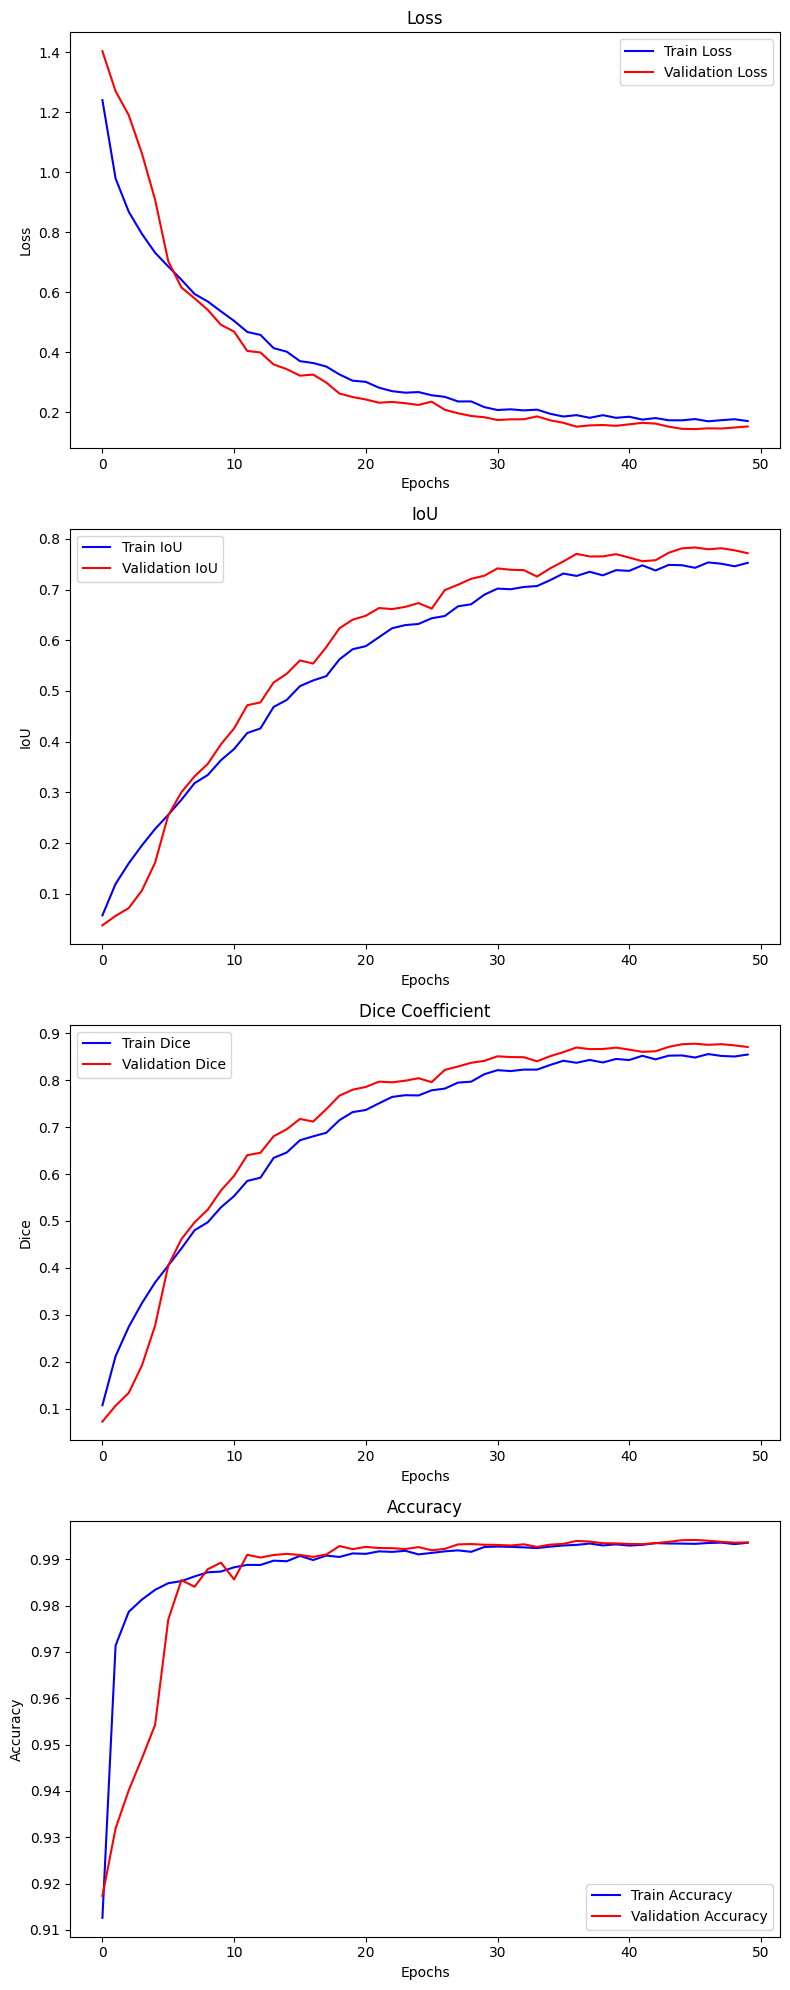

In [ ]:
# Evaluation Visualization
plt.figure(figsize=(8, 20))

# --- Loss ---
plt.subplot(4, 1, 1)
plt.plot(history.history['loss'], 'b-', label='Train Loss')
plt.plot(history.history['val_loss'], 'r-', label='Validation Loss')
plt.legend(loc='best')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# --- IoU ---
plt.subplot(4, 1, 2)
plt.plot(history.history['iou_coef'], 'b-', label='Train IoU')
plt.plot(history.history['val_iou_coef'], 'r-', label='Validation IoU')
plt.legend(loc='best')
plt.title('IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')

# --- Dice Coefficient ---
plt.subplot(4, 1, 3)
plt.plot(history.history['dice_coef'], 'b-', label='Train Dice')
plt.plot(history.history['val_dice_coef'], 'r-', label='Validation Dice')
plt.legend(loc='best')
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice')

plt.subplot(4, 1, 4)
plt.plot(history.history['accuracy'], 'b-', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

### **Trained Model Testing**

In order to evaluate the data with the whole test split we need to create a generator. In this case, the test generator only rescales the images, without augmentation, to evaluate the model on unseen data. 

In [ ]:
loaded_model_seg=load_model("./models/segmentation_ResUNet_final.keras", custom_objects={"bce_dice_loss":bce_dice_loss, "dice_coef":dice_coef, "iou_coef":iou_coef})

In [8]:
test_datagen=ImageDataGenerator(rescale=1./255.)

def test_generator_fn():
  image_generator_test = test_datagen.flow_from_dataframe(
      brain_df_mask_test,
      x_col='image_path',
      class_mode = None,
      color_mode = "rgb",
      target_size = (256,256),
      batch_size = 16,
      seed=42)

  mask_generator_test = test_datagen.flow_from_dataframe(
      brain_df_mask_test,
      x_col = "mask_path",
      class_mode = None,
      color_mode ="grayscale",
      target_size = (256,256),
      batch_size = 16,
      seed=42)

  test_gen_zipped = zip(image_generator_test, mask_generator_test)

  while True:
      for (img, mask) in test_gen_zipped:
          img = img.astype(np.float32)
          mask = mask.astype(np.float32)
          yield (img, mask)

test_generator= test_generator_fn()

In [11]:
prediction_seg = loaded_model_seg.evaluate(test_generator, steps=len(brain_df_mask_test) // 16)

Found 137 validated image filenames.
Found 137 validated image filenames.
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 369ms/step - accuracy: 0.9925 - dice_coef: 0.8458 - iou_coef: 0.7338 - loss: 0.1829


The model’s performance was evaluated using standard classification metrics, **showing excellent results across all measures**. The following scores summarize its effectiveness:

In [12]:
print(f" Test Loss: {prediction_seg[0]:.4f}")
print(f" Test Dice Coefficient: {prediction_seg[1]:.4f}")
print(f" Test IoU: {prediction_seg[2]:.4f}")
print(f" Test Accuracy: {prediction_seg[3]:.4f}")

 Test Loss: 0.1829
 Test Dice Coefficient: 0.8458
 Test IoU: 0.7338
 Test Accuracy: 0.9925


### **Visualization and Comparison of Model Prediction Mask and real mask**

Lastly, we check that the model is doing correct predictions **visualizing the comparisons between the tumor mask established by the health profesional and the predicted mask by our segmentation model**.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


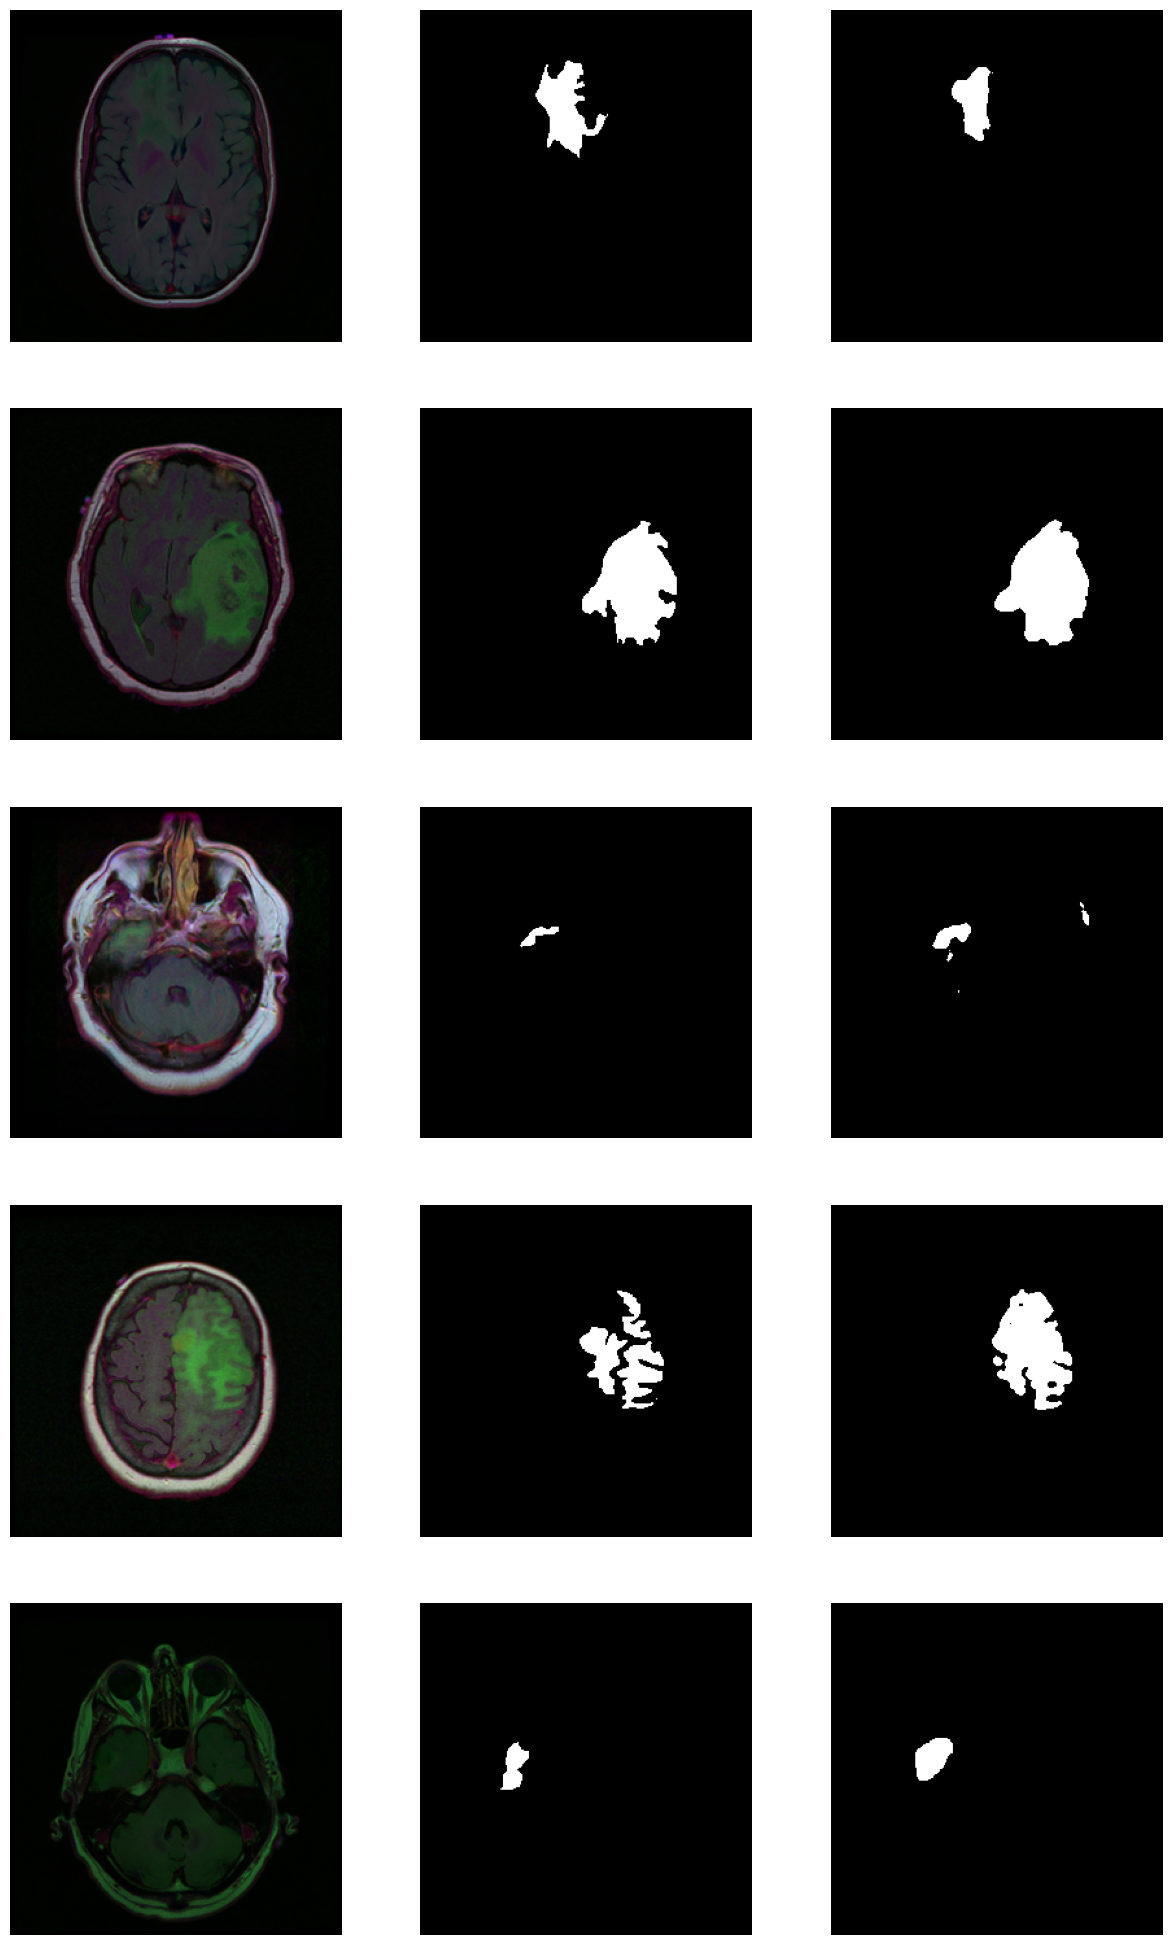

In [11]:
selected_routes=brain_df_mask_test.sample(5)

plt.figure(figsize=(15,25))
for i in range(len(selected_routes)):

  plt.subplot(5,3,1+3*(i))
  image = cv2.cvtColor(io.imread(selected_routes.image_path.iloc[i]), cv2.COLOR_BGR2RGB)/255
  plt.imshow(image)
  plt.axis('off')

  plt.subplot(5,3,2+3*(i))
  true_mask = cv2.cvtColor(io.imread(selected_routes.mask_path.iloc[i]), cv2.COLOR_BGR2RGB)/255
  plt.imshow(true_mask)
  plt.axis('off')


  plt.subplot(5,3,3+3*(i))
  pred_mask=loaded_model_seg.predict(np.expand_dims(image, axis=0))[0]
  pred_mask = (pred_mask > 0.5).astype(np.uint8)
  plt.imshow(pred_mask, cmap='gray')
  plt.axis('off')


In [12]:
# Generate predictions for all test images
image_id = []
mask = []
has_mask = []

print("Generating predictions for test set...")
for i in range(len(brain_df_mask_test)):
    # Get image path
    img_path = brain_df_mask_test.image_path.iloc[i]

    # Read and preprocess image
    image = cv2.cvtColor(io.imread(img_path), cv2.COLOR_BGR2RGB) / 255.0

    # Predict mask
    pred_mask = loaded_model_seg.predict(np.expand_dims(image, axis=0), verbose=0)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # Store results
    image_id.append(img_path)
    mask.append(pred_mask)
    has_mask.append(1)  # All images in brain_df_mask_test have masks

    if (i + 1) % 20 == 0:
        print(f"Processed {i + 1}/{len(brain_df_mask_test)} images")

print(f"Completed! Generated predictions for {len(image_id)} images.")

Generating predictions for test set...
Processed 20/137 images
Processed 40/137 images
Processed 60/137 images
Processed 80/137 images
Processed 100/137 images
Processed 120/137 images
Completed! Generated predictions for 137 images.


In [13]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

image_path  \
0    ./data/TCGA_DU_7010_19860307/TCGA_DU_7010_1986...   
1    ./data/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_1997...   
2    ./data/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_1997...   
3    ./data/TCGA_DU_7018_19911220/TCGA_DU_7018_1991...   
4    ./data/TCGA_DU_8168_19970503/TCGA_DU_8168_1997...   
..                                                 ...   
132  ./data/TCGA_HT_7884_19980913/TCGA_HT_7884_1998...   
133  ./data/TCGA_DU_5871_19941206/TCGA_DU_5871_1994...   
134  ./data/TCGA_HT_8107_19980708/TCGA_HT_8107_1998...   
135  ./data/TCGA_DU_7300_19910814/TCGA_DU_7300_1991...   
136  ./data/TCGA_HT_7860_19960513/TCGA_HT_7860_1996...   

                                        predicted_mask  has_mask  
0    [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
1    [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
2    [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
3    [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
4    [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
..                                                 ...       ...  
132  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
133  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
134  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
135  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
136  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  

[137 rows x 3 columns]

In [14]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = brain_df_mask_test.merge(df_pred, on = 'image_path')
df_pred.head()

image_path  \
0  ./data/TCGA_DU_7010_19860307/TCGA_DU_7010_1986...   
1  ./data/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_1997...   
2  ./data/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_1997...   
3  ./data/TCGA_DU_7018_19911220/TCGA_DU_7018_1991...   
4  ./data/TCGA_DU_8168_19970503/TCGA_DU_8168_1997...   

                                           mask_path  mask  \
0  ./data/TCGA_DU_7010_19860307/TCGA_DU_7010_1986...     1   
1  ./data/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_1997...     1   
2  ./data/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_1997...     1   
3  ./data/TCGA_DU_7018_19911220/TCGA_DU_7018_1991...     1   
4  ./data/TCGA_DU_8168_19970503/TCGA_DU_8168_1997...     1   

                                      predicted_mask  has_mask  
0  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
1  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
2  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
3  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1  
4  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...         1

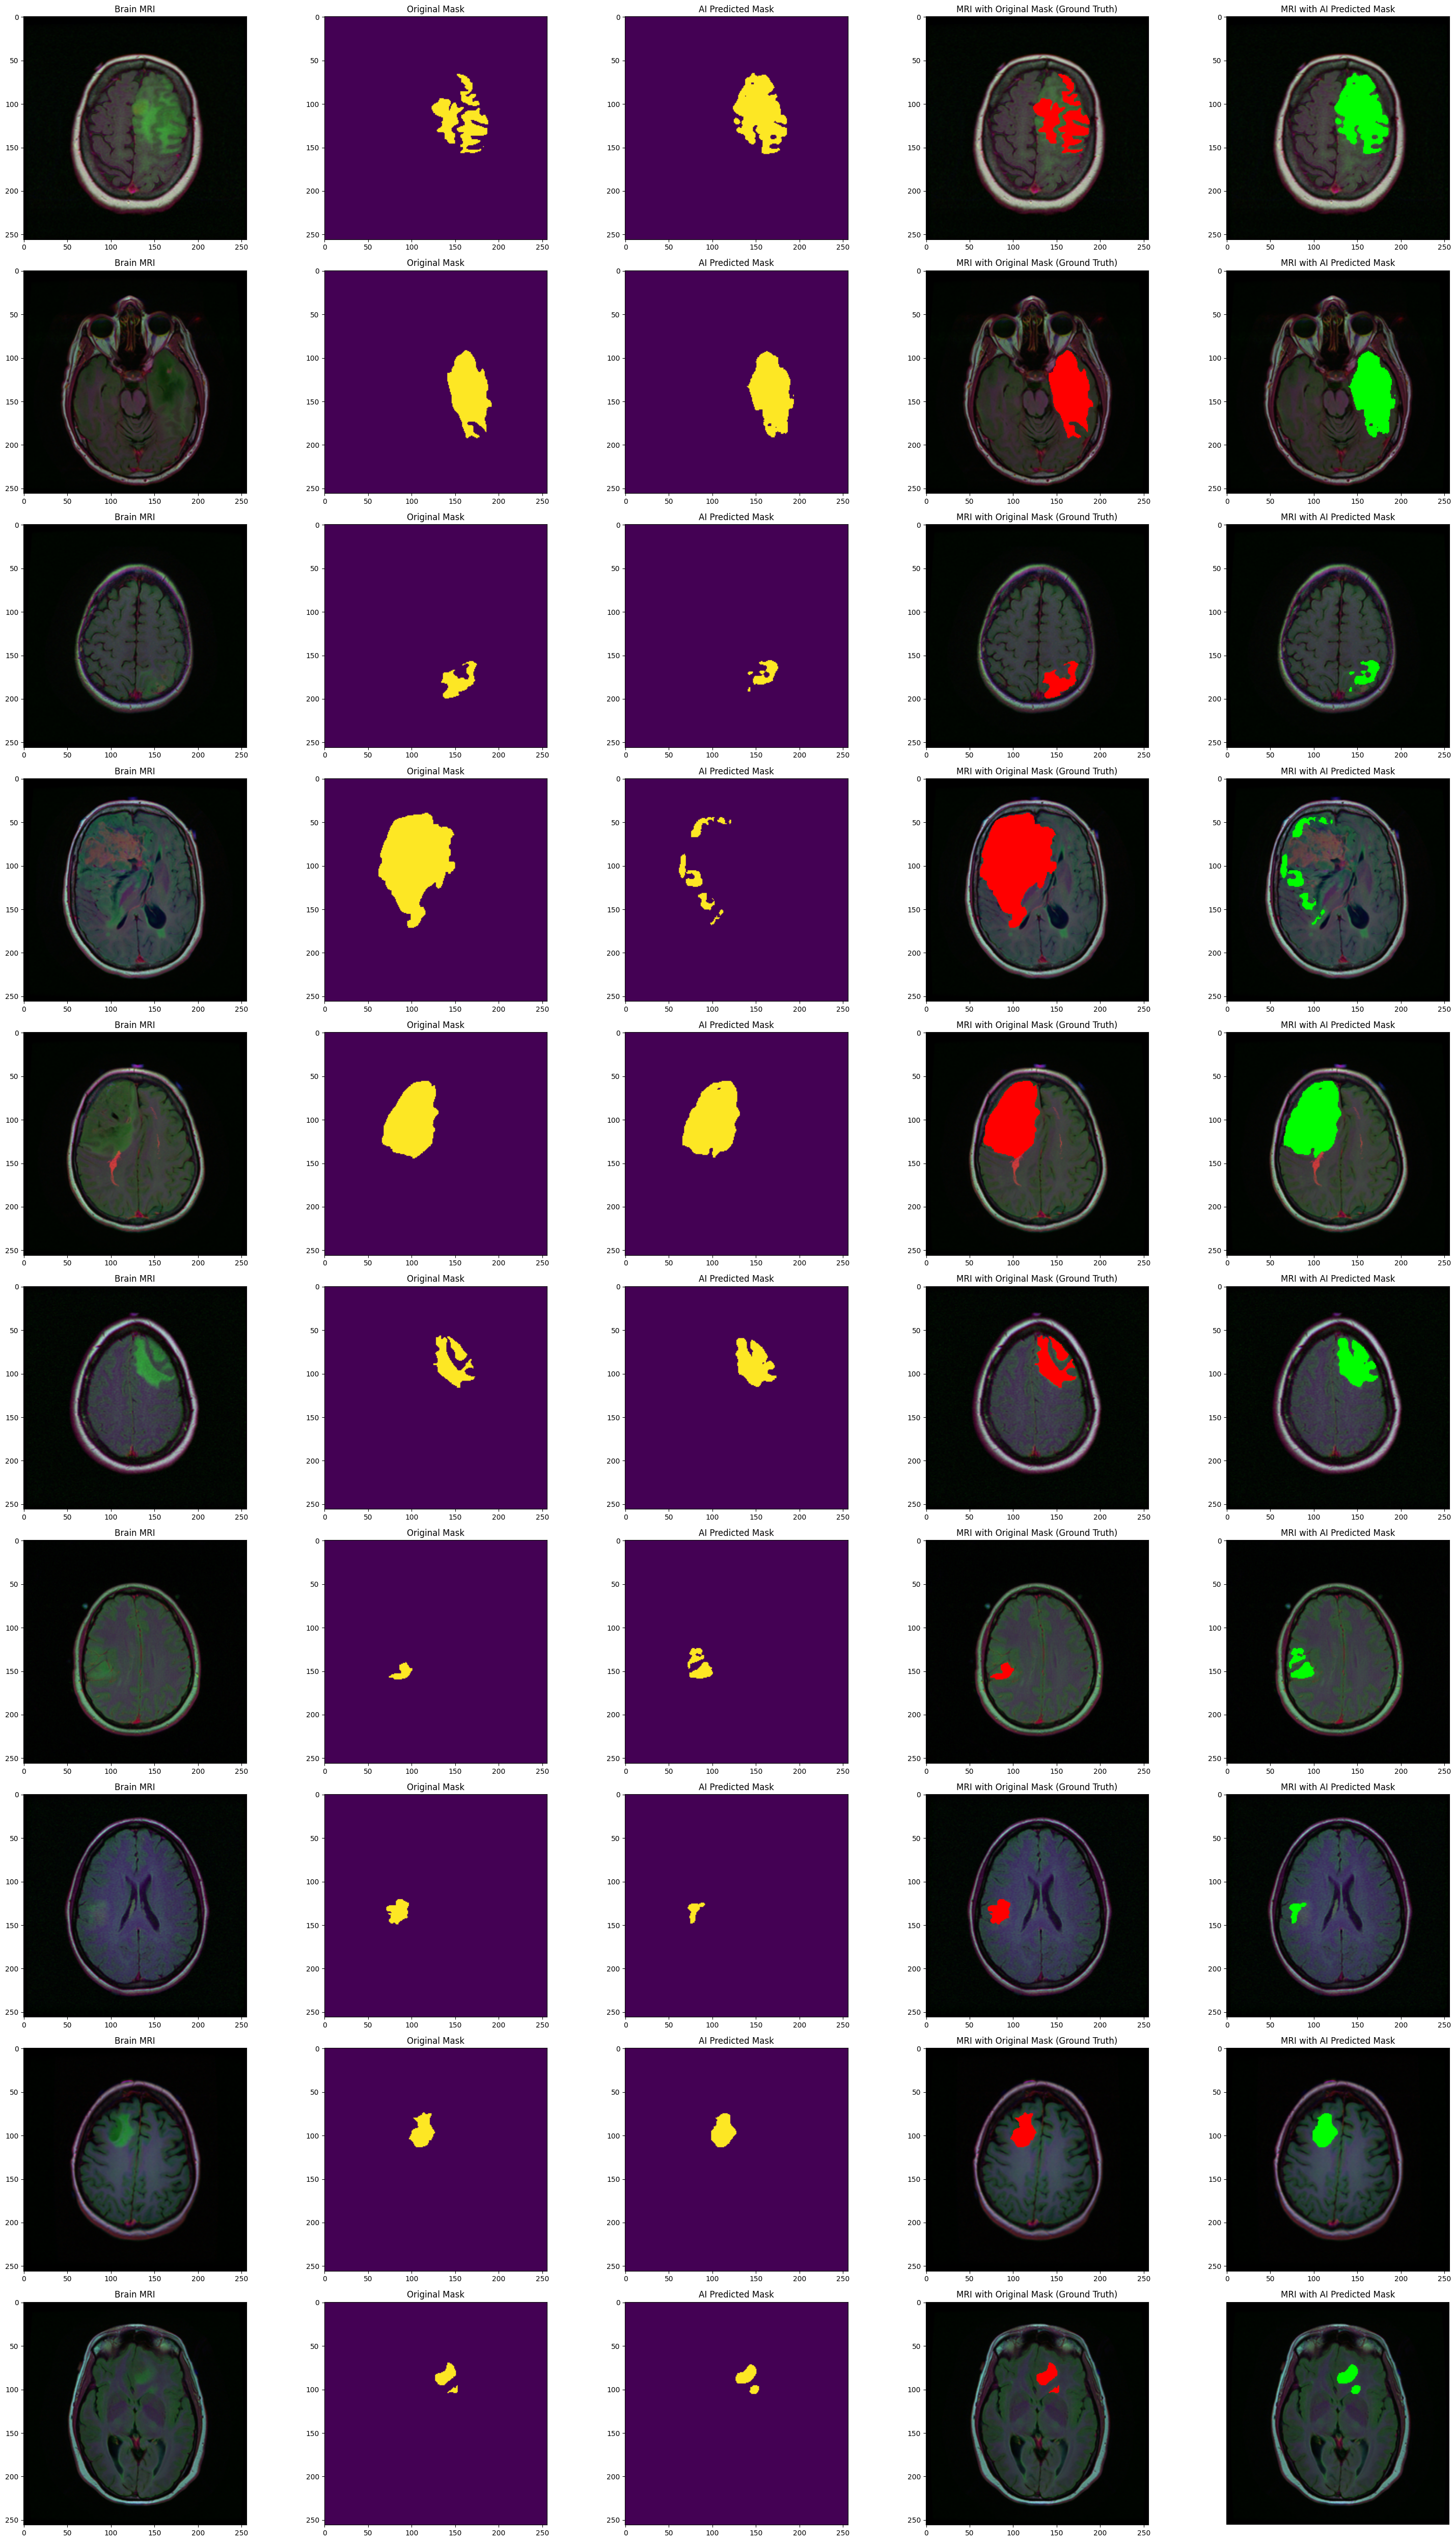

In [20]:
count = 0
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)
    plt.axis('off')

    # Obtain the mask for the image
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)
    plt.axis('off')

    # Obtain the predicted mask for the image
    predicted_mask = np.asarray(df_pred.predicted_mask[i]).squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    plt.axis('off')

    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)
    plt.axis('off')

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    plt.axis('off')
    count += 1

fig.tight_layout()

### **Conclusions**
- **Scalability & Deployment**
By deploying the model through a Flask API backend and a Streamlit frontend, we showed how raw medical imaging data can be transformed into an accessible and practical diagnostic tool for healthcare professionals.

- **Effective Pipeline Implementation**
We implemented a two-stage Deep Learning pipeline that integrates **ResNet-50** for binary classification and **ResUNet** for detailed tumor segmentation.  
This workflow first filters out healthy MRI slices, improving efficiency and enhancing the quality of the final segmentation results.

- **Clinical Impact & Efficiency**
Automating the interpretation of MRI scans reduces human error and delivers faster, more consistent tumor identification compared to manual assessment.  
This contributes to earlier detection—an essential factor in improving survival rates and reducing neurological damage in patients.

- **Patient Safety**
The model uses MRI data, enabling high-resolution structural analysis **without radiation exposure**.  
This makes it suitable for continuous monitoring, particularly important for patients with Low-Grade Gliomas.
